In [5]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Reshape
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [8]:
import os
import pandas as pd

# Define the RAVDESS directory
Ravdess = r"D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24"

# List all directories (actors) in the RAVDESS folder
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

# Loop through each actor folder
for dir in ravdess_directory_list:
    actor_dir = os.path.join(Ravdess, dir)
    if os.path.isdir(actor_dir):  # Check if it's a directory
        actor_files = os.listdir(actor_dir)
        for file in actor_files:
            # Extract the emotion from the filename
            part = file.split('.')[0].split('-')
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_dir, file))

# Create DataFrames for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate emotion and path DataFrames
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace numerical emotion codes with their corresponding labels
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 
    6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Save the DataFrame to a CSV file
Ravdess_df.to_csv("data_path.csv", index=False)

# Display the first few rows of the DataFrame
Ravdess_df.head()


Emotions                                               Path
0  neutral  D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_s...
1  neutral  D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_s...
2  neutral  D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_s...
3  neutral  D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_s...
4     calm  D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_s...

In [10]:
def extract_features(data):
    result = np.array([])
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result


In [11]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sample_rate):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=0.7)


In [13]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    feature = extract_features(data)
    
    X.append(feature)
    Y.append(emotion)  # Original label
    
    # Data augmentation
    for _ in range(3):  # Three augmentations
        aug_data = noise(data)
        X.append(extract_features(aug_data))
        Y.append(emotion)
        
        aug_data = stretch(data)
        X.append(extract_features(aug_data))
        Y.append(emotion)
        
        aug_data = pitch(data, sample_rate)
        X.append(extract_features(aug_data))
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

# One hot encoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)


In [14]:
# Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape for CRNN
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)


In [15]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Flatten

# Create the model
model = Sequential()

# First Conv1D layer
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Second Conv1D layer
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Third Conv1D layer
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Flatten the output to prepare for LSTM
model.add(Flatten())

# LSTM layers
# Reshape is removed since Flatten takes care of the dimensions
model.add(Reshape((21, 64)))  # Use the correct shape here based on your input; ensure this matches your output

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))  # Final LSTM layer

# Dense layers for output
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))  # Adjust output units based on your classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1344)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 21, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,136 (1.21 MB)

 Trainable params: 316,136 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.1908 - loss: 1.9984 - val_accuracy: 0.2908 - val_loss: 1.8026 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.2973 - loss: 1.7901 - val_accuracy: 0.3744 - val_loss: 1.6509 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3883 - loss: 1.6095 - val_accuracy: 0.4331 - val_loss: 1.5021 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4349 - loss: 1.4861 - val_accuracy: 0.4839 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4784 - loss: 1.3875 - val_accuracy: 0.4992 - val_loss: 1.3562 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5026 - loss: 1.3366 - val_accuracy: 0.5539 - val_loss: 1.2094 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5518 - loss: 1

In [18]:
print("Accuracy of our model on test data: ", model.evaluate(x_test, y_test)[1] * 100, "%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9444 - loss: 0.3433
Accuracy of our model on test data:  93.83333325386047 %


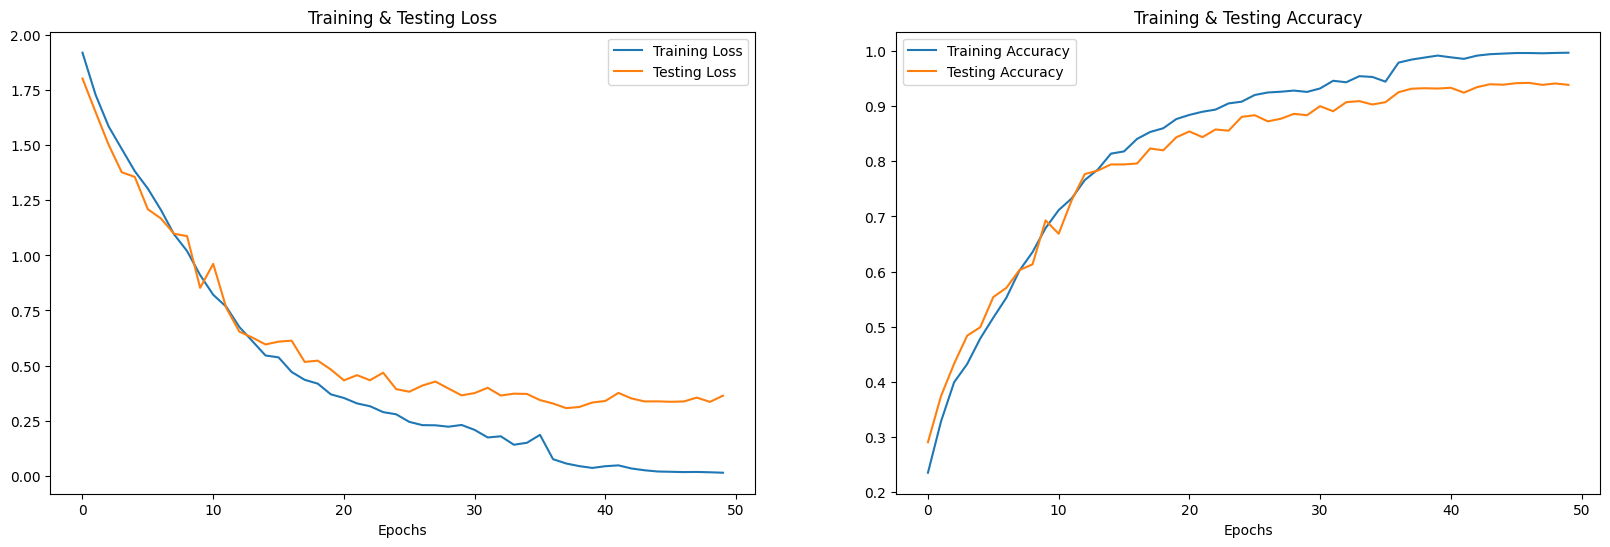

In [19]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


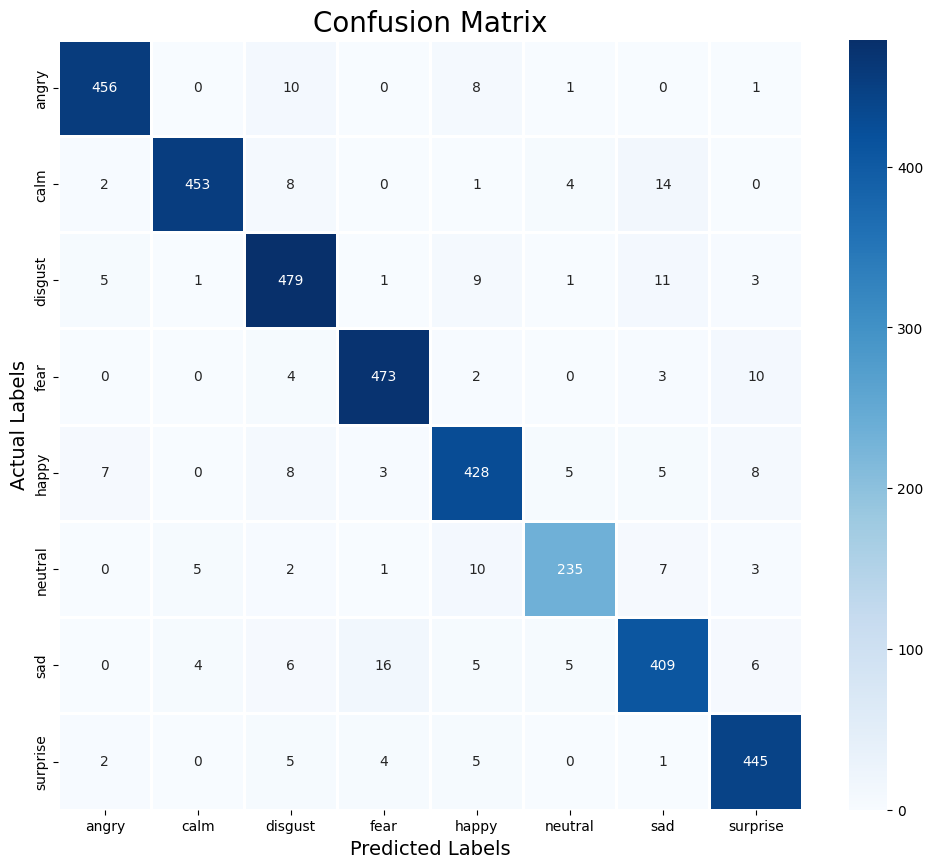

              precision    recall  f1-score   support

       angry       0.97      0.96      0.96       476
        calm       0.98      0.94      0.96       482
     disgust       0.92      0.94      0.93       510
        fear       0.95      0.96      0.96       492
       happy       0.91      0.92      0.92       464
     neutral       0.94      0.89      0.91       263
         sad       0.91      0.91      0.91       451
    surprise       0.93      0.96      0.95       462

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600



In [20]:
# Predictions
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Create DataFrame for predicted and actual labels
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_[0]], columns=[i for i in encoder.categories_[0]])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


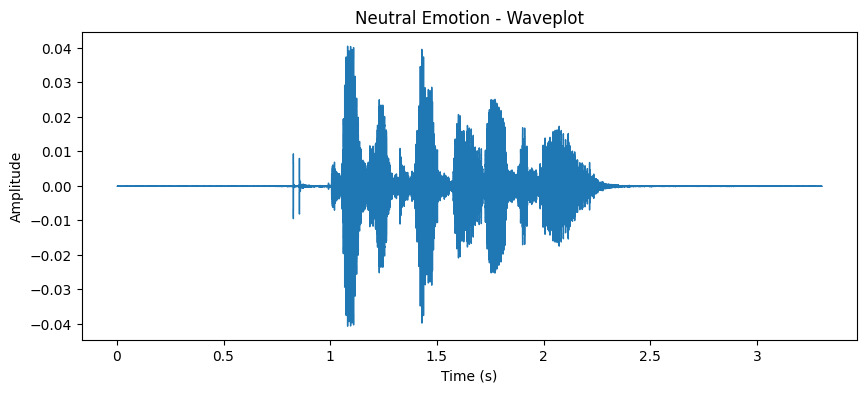

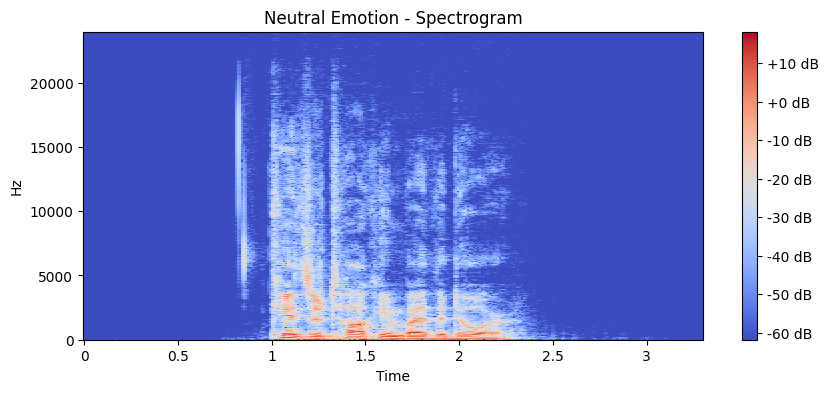

In [28]:
# ----------------- NEUTRAL EMOTION ---------------------
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

# Load the audio file for the "neutral" emotion
emotion = 'neutral'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav'  # Replace with the correct file path
y, sr = librosa.load(file_path, sr=None)

# 1. Waveplot for "neutral" emotion
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# 2. Play the audio for "neutral" emotion
ipd.display(ipd.Audio(y, rate=sr))

# 3. Spectrogram for "neutral" emotion
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




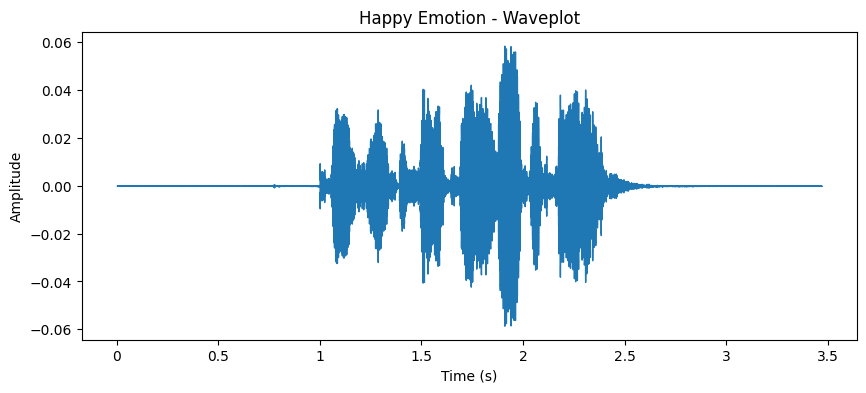

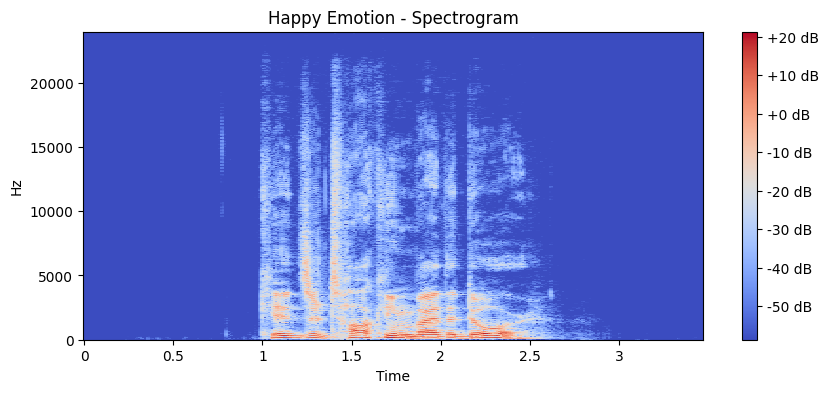

In [30]:
# ----------------- HAPPY EMOTION ---------------------
emotion = 'happy'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-03-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




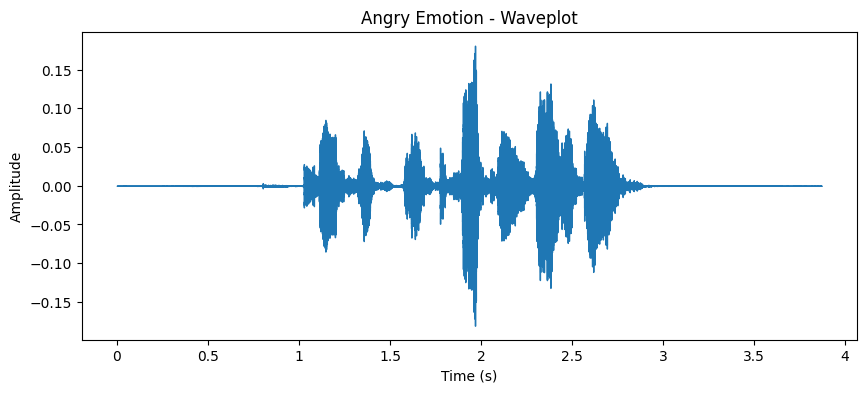

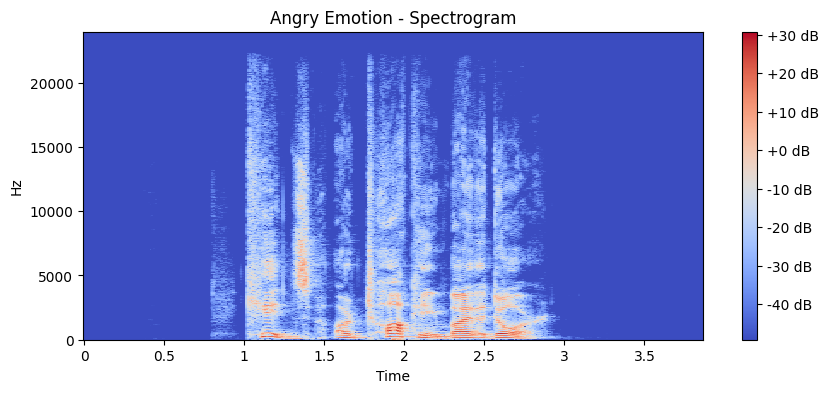

In [31]:
# ----------------- ANGRY EMOTION ---------------------
emotion = 'angry'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-05-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




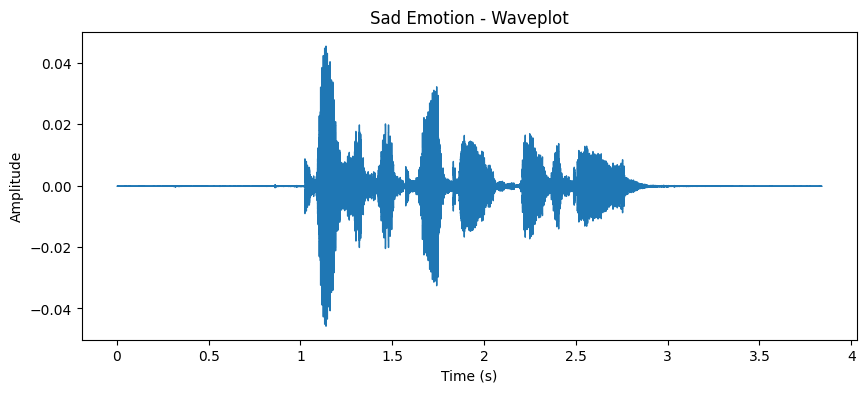

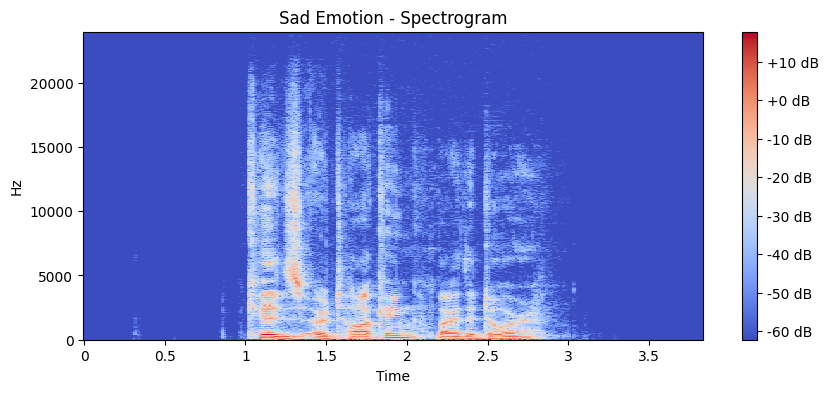

In [32]:
# ----------------- SAD EMOTION ---------------------
emotion = 'sad'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-04-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




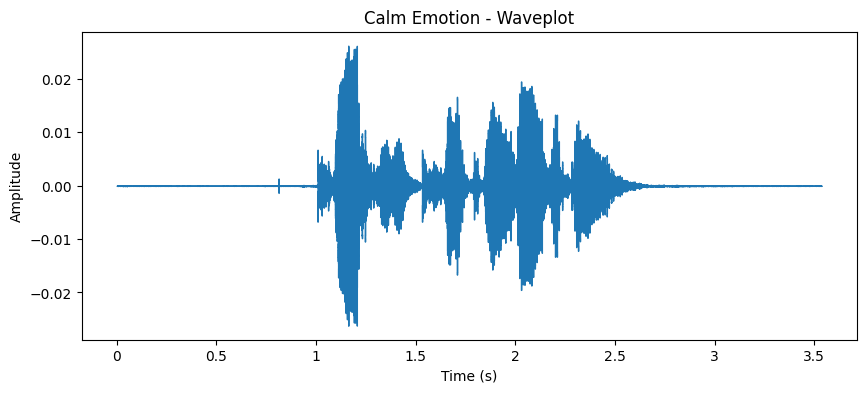

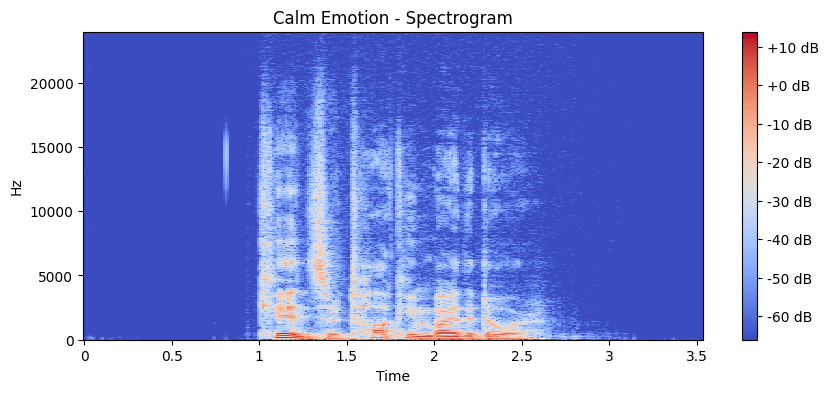

In [33]:
# ----------------- CALM EMOTION ---------------------
emotion = 'calm'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-02-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




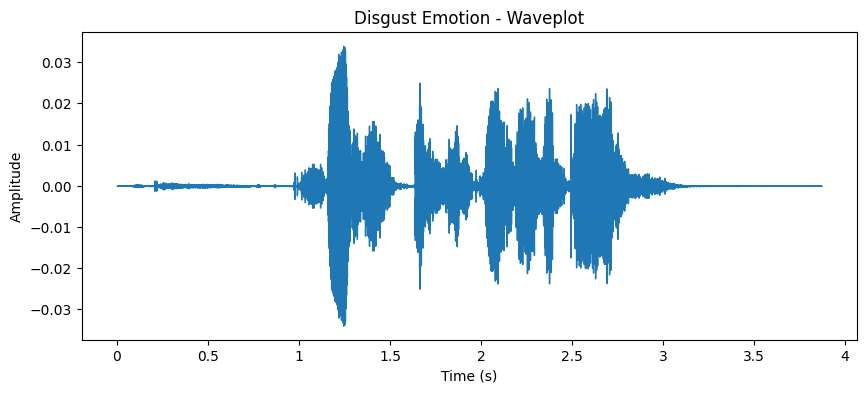

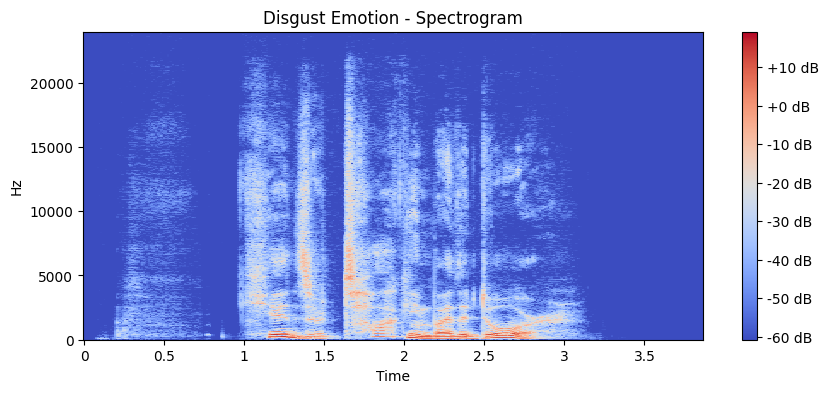

In [34]:
# ----------------- DISGUST EMOTION ---------------------
emotion = 'disgust'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-07-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




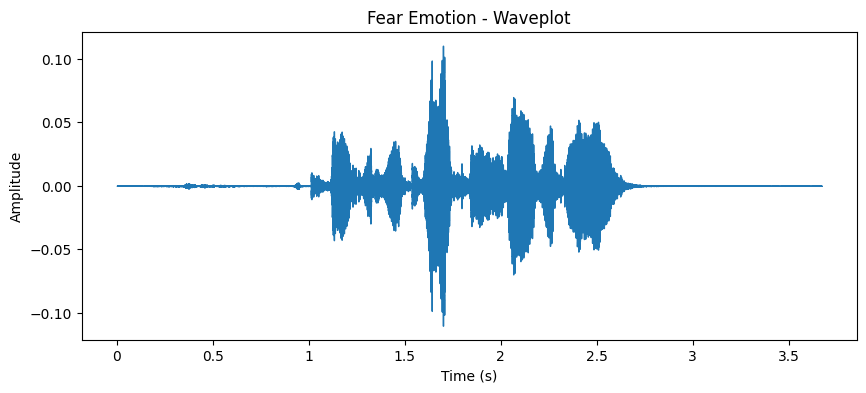

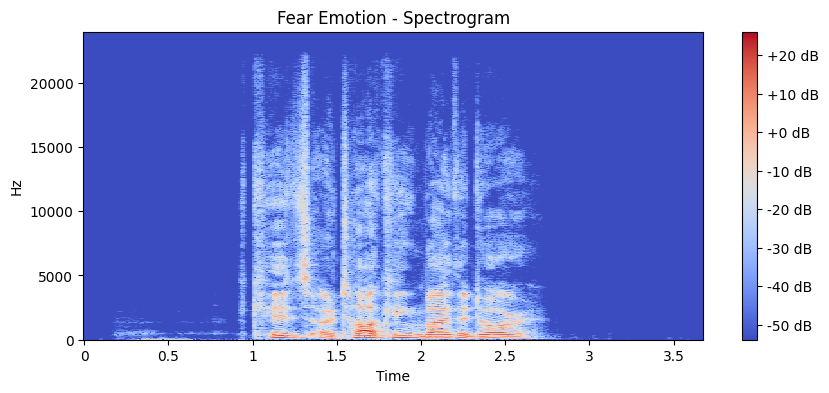

In [35]:
# ----------------- FEAR EMOTION ---------------------
emotion = 'fear'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-06-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()




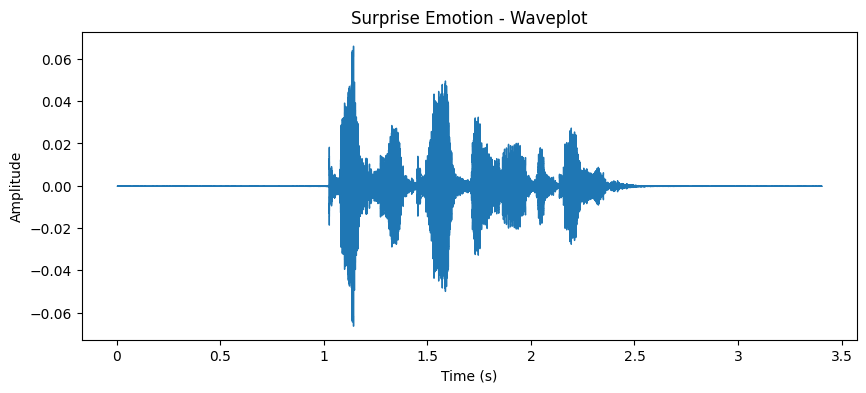

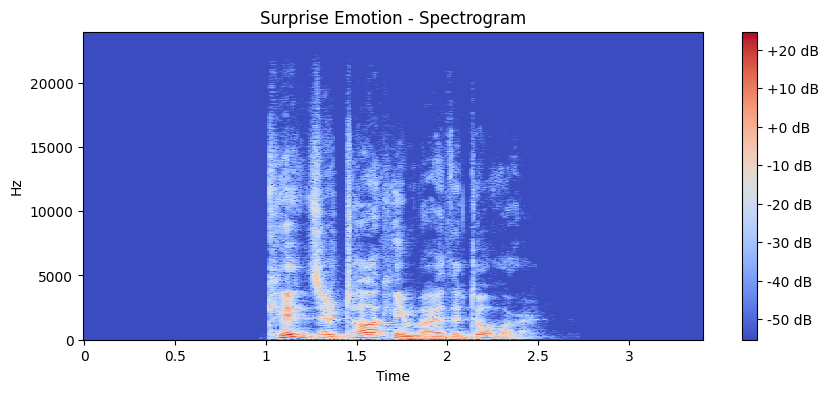

In [36]:
# ----------------- SUPRISE EMOTION ---------------------
emotion = 'surprise'
file_path = r'D:\aravind\A 3RD YEAR STUFF\DL PROJECT\audio_speech_actors_01-24\Actor_01/03-01-08-01-01-01-01.wav'  # Replace with the correct file path

# Waveplot, Spectrogram, and Play Audio
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'{emotion.capitalize()} Emotion - Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

ipd.display(ipd.Audio(y, rate=sr))

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{emotion.capitalize()} Emotion - Spectrogram')
plt.show()


